# CIFAR10 Dataset Analysis

This notebook uses the self-influence results generated by **cifar_10_training.ipynb** to perform analysis and investigate the nature of self-influence.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pickle
import pandas as pd

## Load Results
Models are loaded from pickle files. First entry in the file is always teh averaged self-influence score. A list of models used is created to refer to the specific model in the list.

In [40]:
model_cps = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, -1]

with open('results/scan_results_shuffled_50.pickle', 'rb') as handle:
    scan_results = pickle.load(handle)

In [41]:
LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Results

Method defined to apply cuts on self-influence score

In [42]:
def results_with_cut(results, min_infl = 0, max_infl=1000):
    processed_results = []
    for result in results:
        X = [i for i in result.get("memorisation") if i > min_infl and i < max_infl]
        processed_results.append(X)
    return processed_results

### Plotting influence distributions and boxplots of distribution

Creating a binned histogram of self-influence scores for each saved model (or epoch)

In [43]:
# selection options
MIN = 1
MAX = 1000

processed_results = results_with_cut(scan_results, MIN, MAX)

[Text(0, 0.5, 'Counts'), Text(0.5, 0, 'Self-influence')]

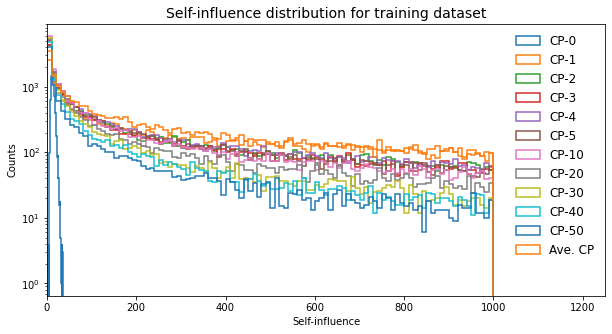

In [44]:
# plot options
BINS = 100
ALPHA = 0.3
X_MAX = MAX + MAX/4

# influence distribution
f, ax = plt.subplots(figsize=(10, 5), ncols=1)
for i in range(len(processed_results)):
    LABEL = "Ave. CP" if model_cps[i]==-1 else"CP-{}".format(model_cps[i]) 
    ax.hist(processed_results[i], bins=BINS, histtype=u'step', linewidth=1.5, label=LABEL)
    
ax.legend(frameon=False, fontsize=12)
ax.set_yscale('log')
ax.set_xlim([0, X_MAX])
ax.set_title("Self-influence distribution for training dataset", fontsize=14)
ax.set(xlabel="Self-influence", ylabel="Counts")

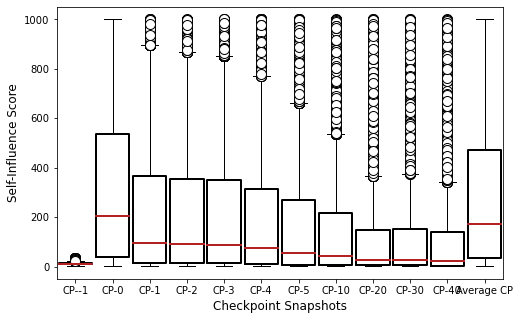

In [45]:
# plot options
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markerfacecolor='white', markersize=10, linestyle='none')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')

# create box plots for different CPs 
f_1, ax_1 = plt.subplots(figsize=(8, 5), ncols=1)

LABELS = []
for i in range(len(processed_results)):
    label = "Average CP" if model_cps[i]==-1 else"CP-{}".format(model_cps[i-1])
    LABELS.append(label)
    
ax_1.set_xticklabels(LABELS, fontdict=None, minor=False)
ax_1.set_xlabel("Checkpoint Snapshots", fontsize=12)
ax_1.set_ylabel("Self-Influence Score", fontsize=12)


ax_1.boxplot(processed_results, widths=0.9, medianprops=medianprops, boxprops=boxprops, flierprops=flierprops)
plt.show()

## Evolution of self-influence

This section investigates how self-influence evolves across different training epochs. We initially need to select a primary model or an epoch to create an ordered self-influence list that a population of examples can be selected from and studied.

In [46]:
# returns an examples index that lies between the desired min and max percentile influence score 
def return_example_index(p_start, p_width, reduced_width, m):
    """
    This function returns the index of a random example between a desired percentile range
    > p_width represents the width of the percentile
    > p_start is used to determine the lowest index 
    > reduced_width is used to select a smaller region within width of percentile
        to return examples closer to the median representation
    > e.g. p_start = 0.2 and p_width = 0.2 will return a random example between the 20th-40th percentile 
    """
    if p_start and p_width > 1:
        print ("Set percentile and width between 0-1.")
    else:
        n = len(m) # length of array
        sorted_m = np.argsort(m) # sorts from smallest to largest influence and returns index ordering
        min_i, max_i = p_start*n, p_start*n + p_width*n # find min and max point given start and width
        median_width = (1 - reduced_width)/2. # calculate the reduced width 
        min_i_median = round(min_i + (p_width*n*median_width))
        max_i_median = round(max_i - (p_width*n*median_width))
        
        # use reduced width to select random example and return index
        return random.choice(sorted_m[min_i_median:max_i_median]) 

In [47]:
# method to return the influence score of a given index
def return_influence_of_index(scan_results, index):
    influence_score = []
    for model in scan_results:
        influence_score.append(model["memorisation"][index])
    return influence_score

Now we're computing the influence scores from examples across different deciles and collecting results for all CP models into a list

In [48]:
m_selected = scan_results[10]["memorisation"] # influence scores from CP 50

p_starts = np.linspace(0, 0.9, 10)

indices = [] # store indices of examples
for p_start in p_starts:
    index = return_example_index(float(p_start), 0.1, 0.1, m_selected)
    indices.append(index)

Finding the influence score for all the given indices

In [49]:
results_for_10_examples = []
for index in indices:
    example_influence_across_CPs = []
    for i, model in enumerate(model_cps):
        if model == -1: 
            continue # skip averaged model
        else:
            infl_score = scan_results[i]["memorisation"][index]
            example_influence_across_CPs.append(infl_score)
    results_for_10_examples.append(example_influence_across_CPs)

Generating a plot of influence score vs different epochs for the 10 examples selected. This plot shows how influence score for a given example evolves over training. Note that the examples are selected from the 50th epoch and projected backwards. 

[Text(0, 0.5, 'Influence Score'), Text(0.5, 0, 'Epochs')]

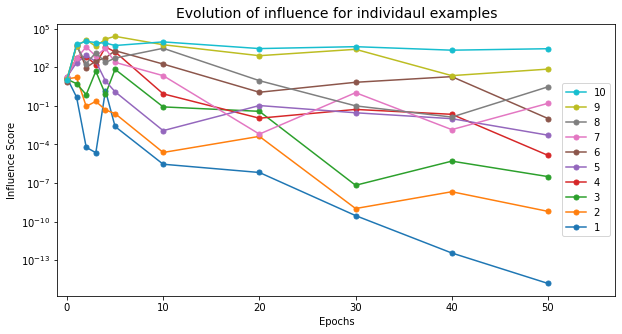

In [50]:
f, ax = plt.subplots(figsize=(10, 5), ncols=1)

for i, value in enumerate(results_for_10_examples):
    LABEL = "{}".format(i+1)                                           
    ax.plot(model_cps[:-1], results_for_10_examples[i], "-o", markersize=5, label=LABEL)

ax.set_xlim([-1, 57])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='right', frameon=True, fontsize=10)
ax.set_yscale('log')
ax.set_title("Evolution of influence for individaul examples", fontsize=14)
ax.set(xlabel="Epochs", ylabel="Influence Score")

### Studying the distributional evolution of influence in tails

In [51]:
# return upper X percentile indices
def return_upper_percentile_indices(p, m):
    """
    > This function returns the indices of the upper pth fraction of most influential examples
    > p represents upper "pth" percentile of the dataset and is set between 0 and 1
    """
    if p > 1:
        print ("Set percentile between 0-1.")
    else:
        n = len(m)
        sorted_m = np.argsort(m)
        min_i, max_i = round(n - p*n), n
        return sorted_m[min_i:max_i]

In [52]:
def return_match_index(scan_results, selected_model, p_width):
    sub_list = return_upper_percentile_indices(p_width, selected_model["memorisation"])
    all_cp_index = []
    for model in range(len(model_cps)):
        index_list = [] # stores matching indices for model
        sorted_model = np.argsort(scan_results[model]["memorisation"]) # sorting model in influence score
        for item in sub_list:
            index_list.append(np.where(sorted_model == item)[0][0])
        all_cp_index.append(index_list)
    return all_cp_index

Using **return_match_index** to count the number of matches between the upper ***p_width*** highest influence examples of a selected epoch/model and all the other epochs/models

In [53]:
p_width=0.25 # percentage of upper influence 
selected_model = scan_results[11]
all_results = return_match_index(scan_results, selected_model, p_width)

In [54]:
# creating a data framework to feed into seaborn plot
data = {
    'CP 0' : all_results[0],
    "CP 1" : all_results[1],
    "CP 2" : all_results[2],
    "CP 3" : all_results[3],
    "CP 4" : all_results[4],
    "CP 5" : all_results[5],
    "CP 10" : all_results[6],
    "CP 20" : all_results[7],
    "CP 30" : all_results[8],
    "CP 40" : all_results[9],
    "CP 50" : all_results[10],
    "CP Ave." : all_results[11]
}
df = pd.DataFrame.from_dict(data, orient='index')
df = df.transpose()
df[:5]

,CP 0,CP 1,CP 2,CP 3,CP 4,CP 5,CP 10,CP 20,CP 30,CP 40,CP 50,CP Ave.
0,42375,16960,42269,39078,46536,21715,16975,38875,23066,23441,31264,36750
1,35359,43048,28762,31416,34935,43353,28070,45661,32254,38766,32507,36751
2,13127,34397,34652,32865,29311,40521,43071,40896,46299,46902,46929,36752
3,4297,38571,37070,38813,40399,37882,45419,30743,29424,25211,36572,36753
4,6326,26227,33894,32117,18688,32840,46088,44812,46205,47373,46865,36754


Text(0, 0.5, 'Ordered influence index')

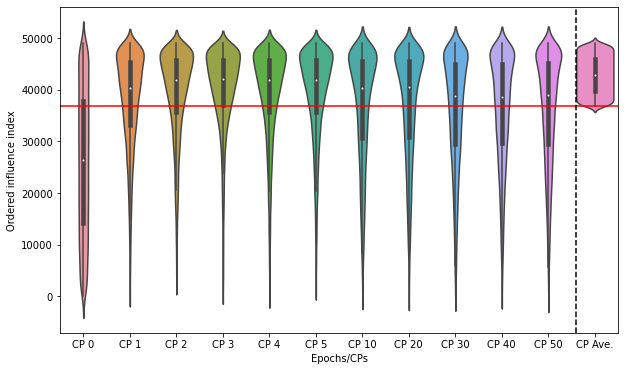

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(ax=ax, data=df)
plt.axhline(y=len(all_results[0])*(1/p_width-1), color='r', linestyle='-')
plt.axvline(x=10.6, color='black', linestyle='--')
plt.xlabel("Epochs/CPs")
plt.ylabel("Ordered influence index")

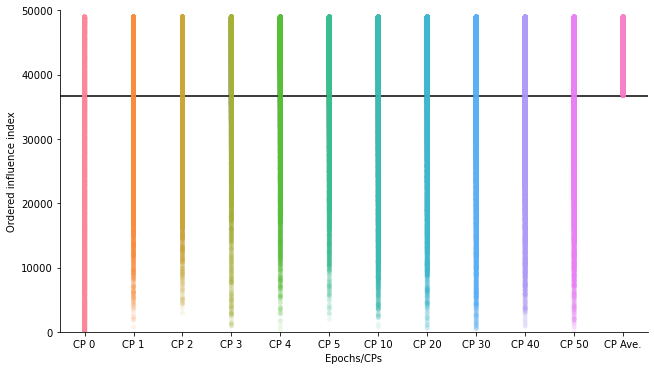

In [56]:
g = sns.catplot(data=df, jitter=False, alpha = .1)
g.fig.set_size_inches(9, 5)
g.map(plt.axhline, y=len(all_results[0])*(1/p_width-1), ls='-', c='k')
axes = plt.gca()
axes.set_ylim([0, 50000])
plt.xlabel("Epochs/CPs")
plt.ylabel("Ordered influence index")
plt.show(g)

## Classification of influencial examples

This section investigates how highly influencial examples are classified through the confusion metrix. Are there certain classes of exmaples or features that lead to high-influence? Preliminary results seem to suggest a high inaccurary rate among highly influencial examples. 

In [57]:
EPOCH_SELECTION = 10
FRAC_SELECTED = 0.02
data = scan_results

In [58]:
# method to return a confusion metrix for highly influencial examples
# > makes use of return_upper_percentile_indices
def return_confusion_metrix(data, epoch_selected, frac_selected):
    ordered_indices = return_upper_percentile_indices(1, data[epoch_selected]["memorisation"])[::-1].flatten()
    frac_selected_int = int(frac_selected * len(ordered_indices))
    true_labels = data[epoch_selected]["labels"][ordered_indices][:frac_selected_int].flatten()
    pred_label = data[epoch_selected]["predicted_labels"][ordered_indices][:frac_selected_int].flatten()
    conf_matrix = [] # stored normalised accuracy. x: predicted y: true
    for class_j in range(10):
        temp_class_count = []
        tot_count = len(pred_label[np.where(true_labels == class_j)[0]])
        for class_i in range(10):
            temp_class_count.append(pred_label[np.where(true_labels == class_j)[0]].tolist().count(class_i)/tot_count)
        conf_matrix.append(temp_class_count)
    return np.array(conf_matrix), true_labels, pred_label

In [59]:
# get confusion matrix. x: predicted y: true
conf_data, true_hist, predicted_hist = return_confusion_metrix(data, EPOCH_SELECTION, FRAC_SELECTED)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/matrix.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


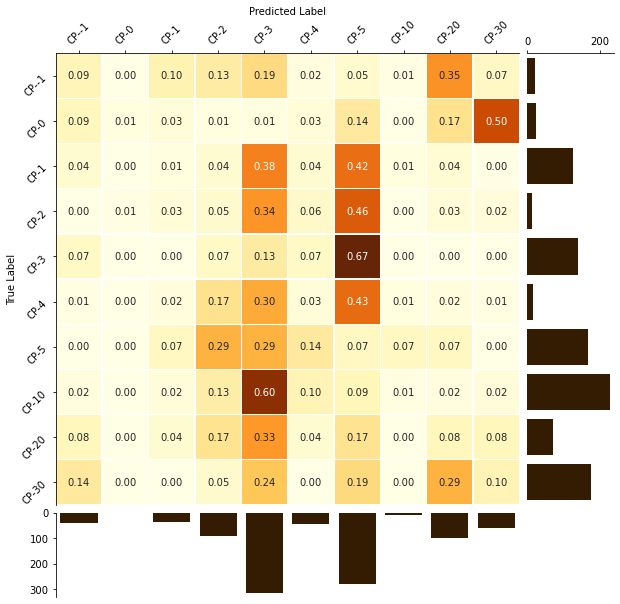

In [60]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 10), tight_layout=True)
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=0.2, hspace=0.2)


# 1st plot
#---------
ax_1 = fig.add_subplot(gs[:10,:10])
sns.heatmap(conf_data, 
            linewidths=.3, 
            annot=True, fmt=".2f", 
            cmap="YlOrBr", cbar=False, ax=ax_1)

ax_1.xaxis.set_ticks_position("top")
ax_1.xaxis.set_label_position('top')
ax_1.tick_params(axis = "x", which = "both", bottom = False)
ax_1.set_xticklabels(LABELS, rotation=45)
ax_1.set_xlabel('Predicted Label')

ax_1.set_yticklabels(LABELS, rotation=45)
ax_1.set_ylabel('True Label')

ax_1.spines["right"].set_visible(False)
ax_1.spines["left"].set_visible(True)
ax_1.spines["top"].set_visible(True)
ax_1.spines["bottom"].set_visible(False)

# 2st plot bottom
#---------

ax_2 = fig.add_subplot(gs[10:, :10])
ax_2.bar(np.arange(10), np.bincount(predicted_hist), color="#341c02")
ax_2.set_xlim(-0.5, 9.5)
ax_2.invert_yaxis()

ax_2.tick_params(axis = "x", which = "both", bottom = False)
ax_2.set_xticklabels([])

ax_2.spines["right"].set_visible(False)
ax_2.spines["left"].set_visible(True)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)

# 3st plot right
#---------
ax_3 = fig.add_subplot(gs[:10, 10:])
ax_3.barh(np.arange(10), np.bincount(true_hist), color="#341c02")
ax_3.set_ylim(-0.5, 9.5)

ax_3.xaxis.set_ticks_position("top")
ax_3.tick_params(axis = "y", which = "both", left = False)
ax_3.set_yticklabels([])

ax_3.spines["right"].set_visible(False)
ax_3.spines["left"].set_visible(False)
ax_3.spines["top"].set_visible(True)
ax_3.spines["bottom"].set_visible(False)



## Create pruned datasets
This section is used to create and save pruned datasets. The indices are selected by removing a percentage of the most influential examples from the last epoch (50th). The indices are saved as lists into a pickle file to be used in training.

In [61]:
def prune_dataset(data, epoch_index, prune_frac):
    all_indices = list(range(len(data[epoch_index]["memorisation"])))
    indices_to_remove = return_upper_percentile_indices(prune_frac, 
                                                  data[epoch_index]["memorisation"])[::-1].flatten()
    pruned_list = np.delete(all_indices, indices_to_remove)
    return sorted(pruned_list)

In [62]:
EPOCH = 50
epoch_index = model_cps.index(EPOCH)
prune_frac = 0.01
data = scan_results

In [63]:
pruned_datasets = []
prune_frac_scan = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25]
for i, prune_frac in enumerate(prune_frac_scan):
    pruned_datasets.append(np.array(prune_dataset(data, epoch_index, prune_frac)).flatten())

In [64]:
pruned_datasets_dict = {
    "frac_list" : prune_frac_scan,
    "pruned_datasets" : pruned_datasets
}

In [65]:
# save options
EXTENSION = "pruned_datasets"

# store data (serialize)
with open('results/{}.pickle'.format(EXTENSION), 'wb') as handle:
    pickle.dump(pruned_datasets_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)